In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings as warn
from warnings import filterwarnings
filterwarnings("ignore")

In [5]:
# read datasets
data= pd.read_csv('twitter_training.csv')
data.head()

,2401,Borderlands,Positive,"im getting on borderlands and i will murder you all ,"
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...


the columns are unnamed as we can see 

In [6]:
data= pd.read_csv('twitter_training.csv',names=['UserID', 'Trend', 'Sentiments', 'Text'])
data.head()

,UserID,Trend,Sentiments,Text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [7]:
data.shape

(74682, 4)

In [8]:
data.dtypes

UserID         int64
Trend         object
Sentiments    object
Text          object
dtype: object

# EDA & Data pre-processing

In [9]:
#check on duplicates
data.duplicated().sum()

2700

In [10]:
data.drop_duplicates(inplace=True)

In [11]:
data.isna().sum()

UserID          0
Trend           0
Sentiments      0
Text          326
dtype: int64

In [12]:
#to know the tatal null in percent 
print((data.isna().sum()/len(data))*100)

UserID        0.000000
Trend         0.000000
Sentiments    0.000000
Text          0.452891
dtype: float64


In [13]:
#the best method in this case to drop them 
data.dropna(axis = 0 , inplace= True)

In [14]:
data.isna().sum()

UserID        0
Trend         0
Sentiments    0
Text          0
dtype: int64

In [15]:
data.shape

(71656, 4)

# Visualization

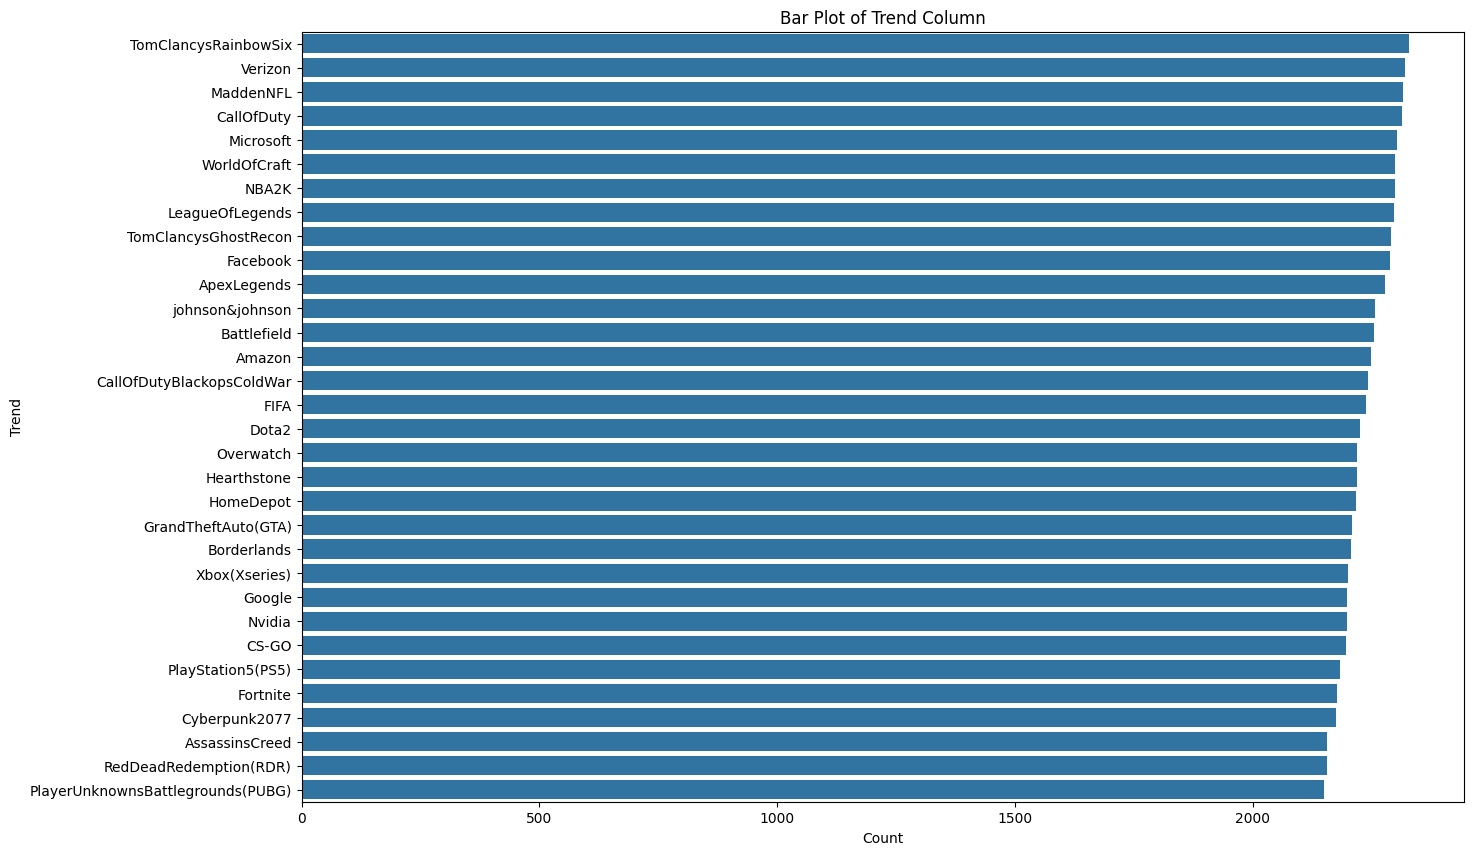

In [16]:
trend_counts = data['Trend'].value_counts()

plt.figure(figsize=(15,10))
sns.barplot(x=trend_counts.values, y=trend_counts.index)

plt.xlabel('Count')
plt.ylabel('Trend')
plt.title('Bar Plot of Trend Column')

plt.show()

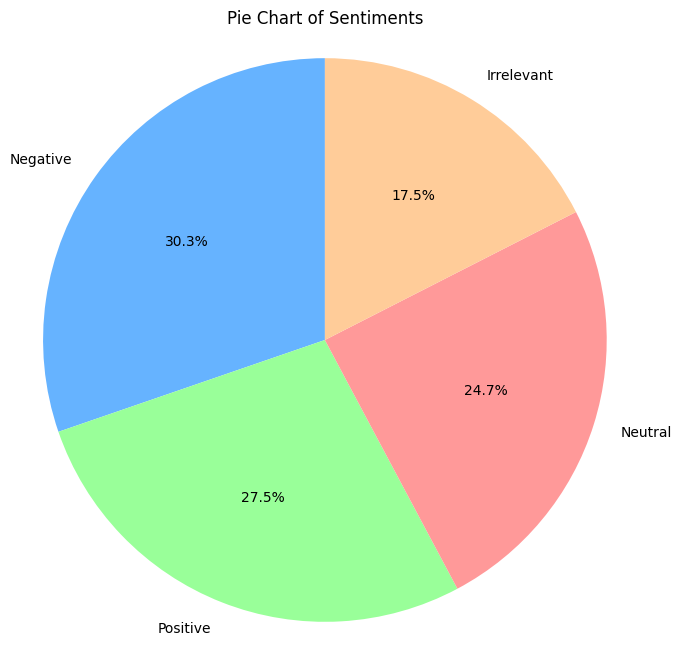

In [17]:
sentiment_counts = data['Sentiments'].value_counts()

plt.figure(figsize=(8,8))
plt.pie(sentiment_counts.values, labels=sentiment_counts.index, autopct='%1.1f%%', startangle=90, colors=['#66b3ff','#99ff99','#ff9999','#ffcc99'])

plt.title('Pie Chart of Sentiments')
plt.axis('equal')
plt.show()

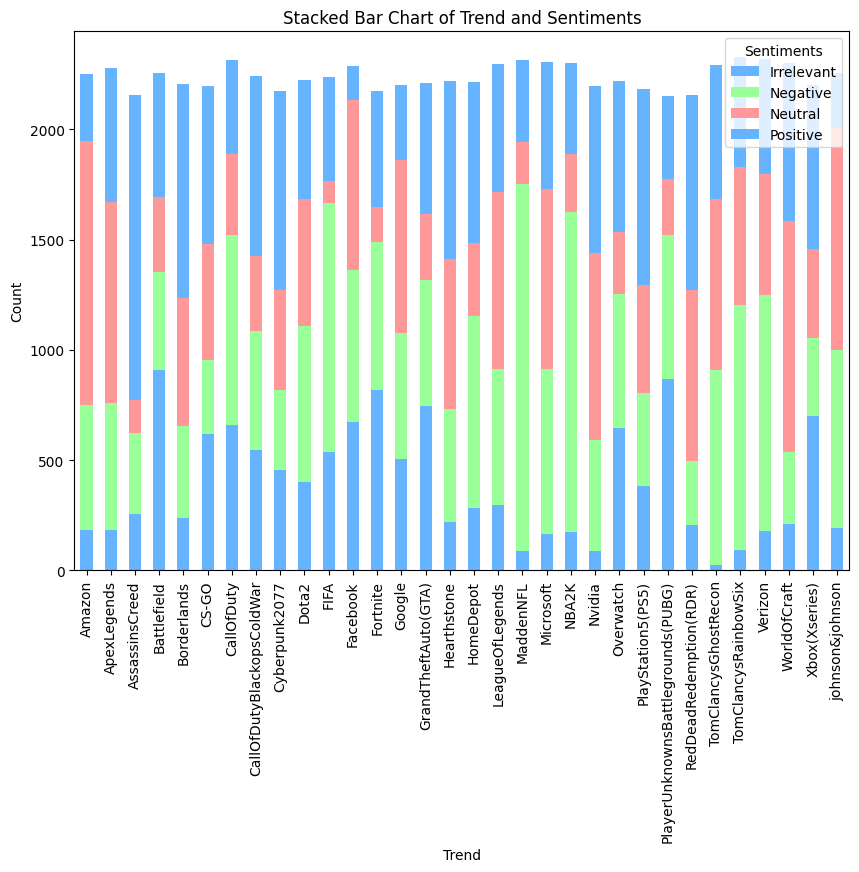

In [18]:
trend_sentiment = pd.crosstab(data['Trend'], data['Sentiments'])
trend_sentiment.plot(kind='bar', stacked=True, figsize=(10,7), color=['#66b3ff','#99ff99','#ff9999'])

plt.xlabel('Trend')
plt.ylabel('Count')
plt.title('Stacked Bar Chart of Trend and Sentiments')

plt.show()

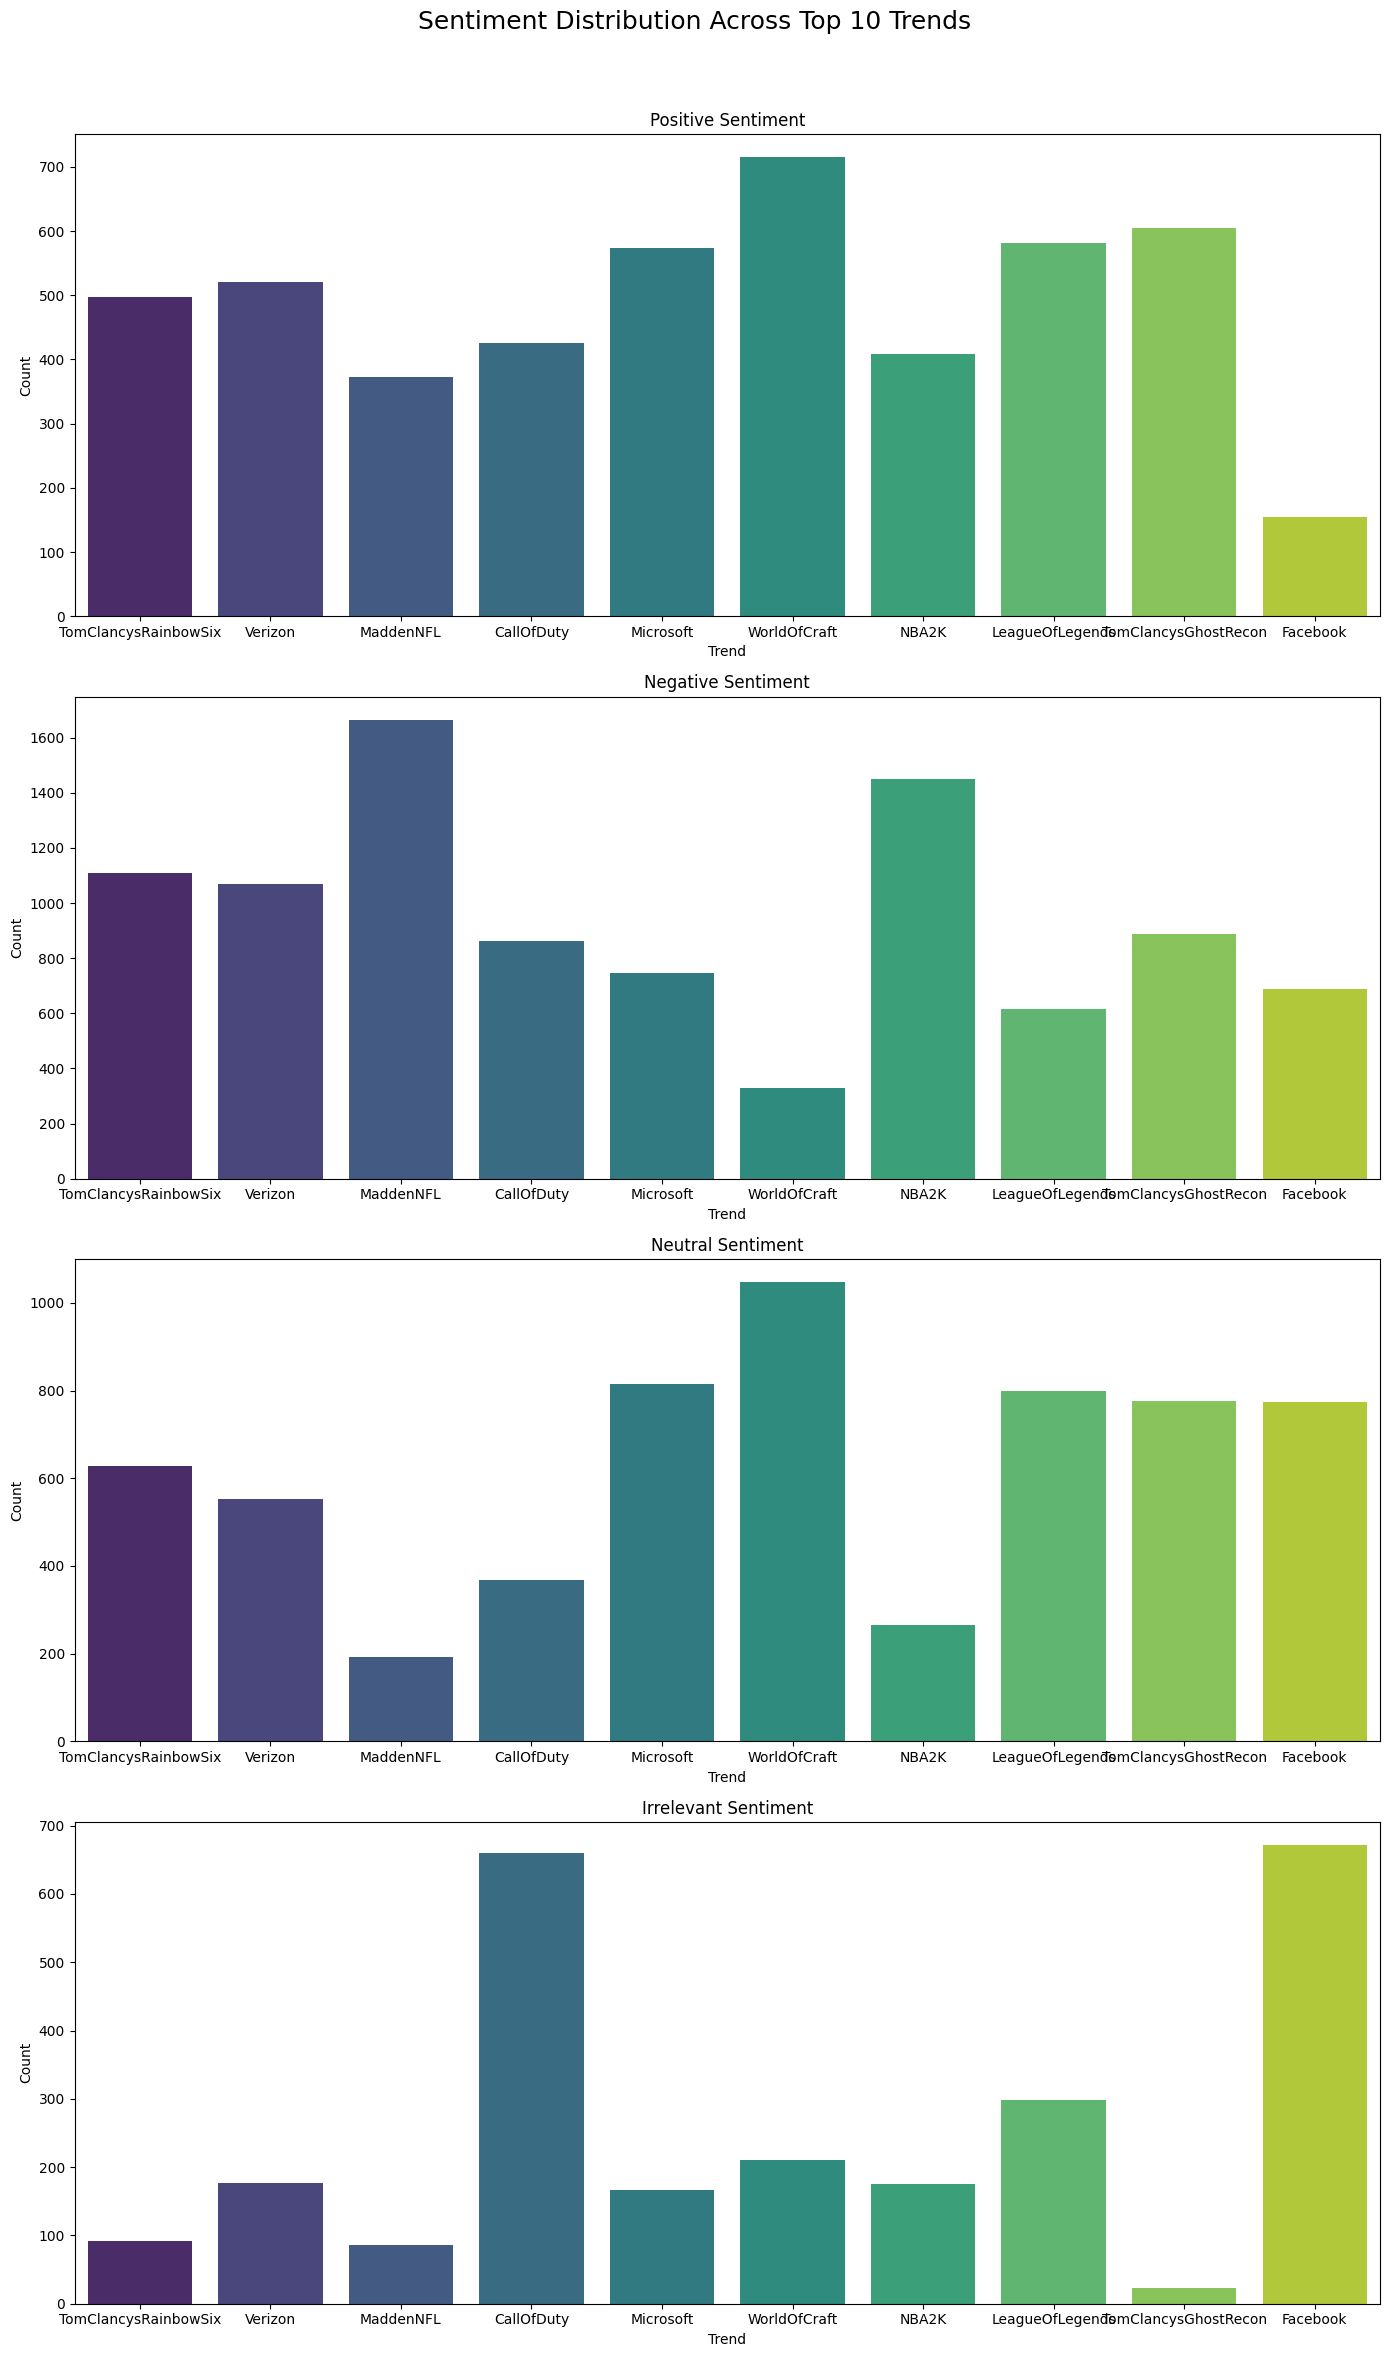

In [19]:
# Get the top 10 most frequent trends
top_10_trends = data['Trend'].value_counts().nlargest(10).index

# Filter the dataset for only the top 10 trends
top_10_data = data[data['Trend'].isin(top_10_trends)]

fig, axes = plt.subplots(4, 1, figsize=(14, 24))
fig.suptitle('Sentiment Distribution Across Top 10 Trends', fontsize=18)
sentiments = ['Positive', 'Negative', 'Neutral', 'Irrelevant']

for sentiment, ax in zip(sentiments, axes.flatten()):
    filtered_data = top_10_data[top_10_data['Sentiments'] == sentiment]
    sns.countplot(data=filtered_data, x='Trend', ax=ax, palette='viridis', order=top_10_trends)
    
    ax.set_title(f'{sentiment} Sentiment')
    ax.set_xlabel('Trend')
    ax.set_ylabel('Count')

plt.tight_layout(rect=[0, 0, 1, 0.96])

plt.show()

In [20]:
import re
import string
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
nltk.download('stopwords')

# Function to clean the text
def clean_text(text):
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = text.lower()
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

data['Cleaned_Text'] = data['Text'].apply(clean_text)

# Vectorize the cleaned text using TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=5000)
X = tfidf_vectorizer.fit_transform(data['Cleaned_Text'])


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ARIFr\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


In [21]:
#encode 
data = pd.get_dummies(data, columns=['Trend'], drop_first=True)

# Splitting Data

In [22]:
from sklearn.model_selection import train_test_split
y = data['Sentiments']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Logistic Regression

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

print(f'Accuracy: {accuracy_score(y_test, y_pred)}')
print(classification_report(y_test, y_pred))


Accuracy: 0.6830867987719788
              precision    recall  f1-score   support

  Irrelevant       0.68      0.52      0.59      2529
    Negative       0.74      0.78      0.76      4383
     Neutral       0.63      0.65      0.64      3543
    Positive       0.67      0.71      0.69      3877

    accuracy                           0.68     14332
   macro avg       0.68      0.67      0.67     14332
weighted avg       0.68      0.68      0.68     14332



# Grid Search &Tuning the Hyperparameter

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']}
grid_search = GridSearchCV(LogisticRegression(), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.1, 1, 10], 'solver': ['liblinear', 'lbfgs']},
             scoring='accuracy')

# Decision Tree

In [25]:
from sklearn.tree import DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(random_state=42)

# Train the model
dt_classifier.fit(X_train, y_train)

# Predict on the test set
y_pred = dt_classifier.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')
print(classification_report(y_test, y_pred))

Accuracy: 0.776793190064192
              precision    recall  f1-score   support

  Irrelevant       0.77      0.68      0.72      2529
    Negative       0.84      0.81      0.82      4383
     Neutral       0.79      0.76      0.77      3543
    Positive       0.71      0.82      0.76      3877

    accuracy                           0.78     14332
   macro avg       0.78      0.77      0.77     14332
weighted avg       0.78      0.78      0.78     14332

